In [4]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
max_degree = 20 # 生成一个20维的向量
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [6]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.3926],
         [-0.1971]]),
 tensor([[ 1.0000e+00,  3.9256e-01,  7.7052e-02,  1.0083e-02,  9.8951e-04,
           7.7689e-05,  5.0830e-06,  2.8505e-07,  1.3988e-08,  6.1012e-10,
           2.3951e-11,  8.5474e-13,  2.7962e-14,  8.4436e-16,  2.3676e-17,
           6.1962e-19,  1.5202e-20,  3.5105e-22,  7.6561e-24,  1.5818e-25],
         [ 1.0000e+00, -1.9711e-01,  1.9427e-02, -1.2764e-03,  6.2900e-05,
          -2.4797e-06,  8.1462e-08, -2.2939e-09,  5.6520e-11, -1.2379e-12,
           2.4400e-14, -4.3723e-16,  7.1820e-18, -1.0890e-19,  1.5332e-21,
          -2.0148e-23,  2.4821e-25, -2.8780e-27,  3.1516e-29, -3.2696e-31]]),
 tensor([5.2712, 4.6437]))

In [7]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [8]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.008722   1.2207366 -3.3949623  5.585942 ]]


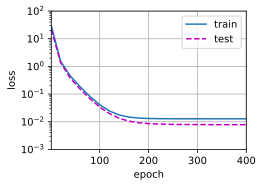

In [10]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.065536 4.014141]]


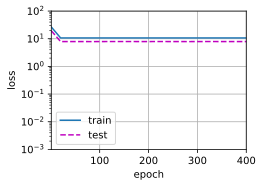

In [13]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 5.0102854   1.3048034  -3.4156542   5.1497645   0.03866126  1.2160044
   0.16914661 -0.10108263 -0.11531459  0.15235905  0.11382856  0.04193605
   0.09186782 -0.03405394  0.21768057  0.1064044  -0.21055214  0.01479841
   0.17359915 -0.09508206]]


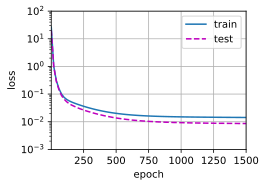

In [14]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)